# Variational Inference

We will look at two different variational methods to infer an interpretable structure from a streaming high-dimensional time series: sequential variational encoder (seqVAE) and variational joint filtering (VJF).



In [11]:
import h5py
import torch
import numpy as np
import matplotlib.pyplot as plt

from code_pack.generate_vdp_data import generate_van_der_pol, generate_noisy_van_der_pol
from vjf.model import VJF
import math
from einops import rearrange

from vanderpol.config import get_cfg_defaults
cfg = get_cfg_defaults()

In [12]:
# Setup precision and random seeds
torch.set_default_dtype(torch.double)  # using double precision
np.random.seed(0)
torch.manual_seed(0);

In [13]:
def plot_vector_field(dynamics_fn, axs, axs_range):
    x = np.linspace(min(axs_range['x_min'], -1.5), max(axs_range['x_max'],1.5), 50)
    y = np.linspace(min(axs_range['y_min'], -1.5), max(axs_range['y_max'], 1.5), 50)

    X, Y = np.meshgrid(x, y)
    u, v = np.zeros(X.shape), np.zeros(Y.shape)
    NI, NJ = Y.shape

    for i in range(NI):
        for j in range(NJ):
            x = X[i, j]
            y = Y[i, j]

            vec_in = torch.tensor([x, y], dtype=torch.float32)
            vec_out = dynamics_fn(vec_in)
            s = (vec_out - vec_in).cpu().data.numpy()

            u[i, j] = s[0]
            v[i, j] = s[1]

    axs.streamplot(X, Y, u, v, color='black', linewidth=0.5, arrowsize=0.5)
    
def grid(n, lims):
    xedges = np.linspace(*lims, n)
    yedges = np.linspace(*lims, n)
    X, Y = np.meshgrid(xedges, yedges)
    grids = np.column_stack([X.reshape(-1), Y.reshape(-1)])
    return X, Y, grids

### Load data

In [35]:
cfg = get_cfg_defaults()
data = h5py.File('vanderpol/data/poisson_obs.h5')
Y = torch.tensor(np.array(data['Y']), dtype=torch.float32)
X = torch.tensor(np.array(data['X']), dtype=torch.float32)
C = torch.tensor(np.array(data['C']), dtype=torch.float32)
b = torch.tensor(np.array(data['bias']), dtype=torch.float32)

### Generate data 

## Sequential Variational AutoEncoder

We demonstrate that seqVAE can learn the latent dynamical system.
For fast convergence, we fix the observation model parameters.

In [42]:
from vanderpol.config import get_cfg_defaults
from vanderpol.SequentialVAE import NeuralVAE, SeqDataLoader
from IPython.display import display, clear_output

n_epochs = 150
batch_size = 25
time_delta = 5e-3

n_latents = X.shape[2]
n_neurons = Y.shape[2]
n_time_bins = Y.shape[1]

In [43]:
vae = NeuralVAE(cfg, time_delta, n_neurons, n_latents, n_time_bins)
vae.manually_set_readout_params(torch.tensor(C), torch.tensor(b))

vae.decoder.C.bias.requires_grad_(False)
vae.decoder.C.weight.requires_grad_(False)
train_data_loader = SeqDataLoader((Y, X), batch_size)

opt = torch.optim.Adam(vae.parameters(), lr=1e-2)

C:\Users\abel_\AppData\Local\Temp\ipykernel_3032\1000452694.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  vae.manually_set_readout_params(torch.tensor(C), torch.tensor(b))



KeyboardInterrupt



Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x000002189BD979D0> (for post_execute):



KeyboardInterrupt



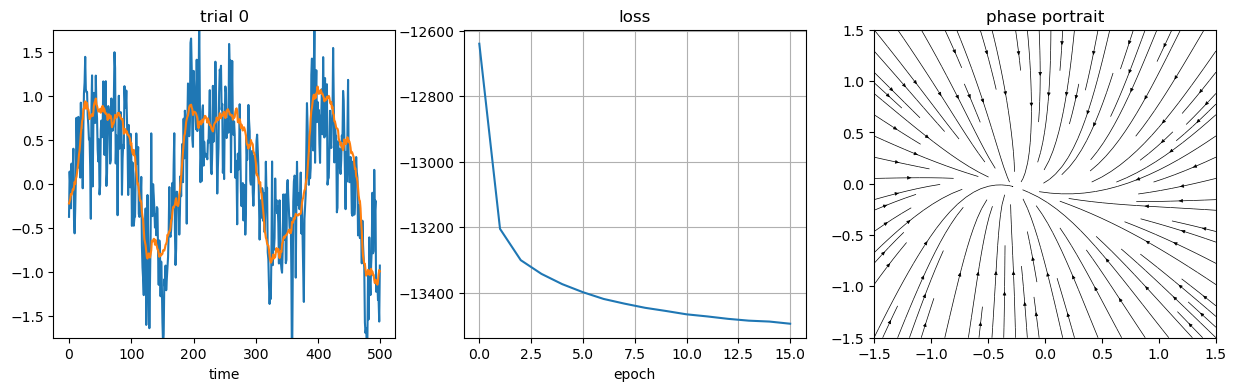

In [44]:
# fig, axs = plt.subplots(1, 2, figsize=(10, 3))
%matplotlib notebook
%matplotlib inline
# fig = plt.figure()
# axs = fig.add_subplot(1, 1, 1)
total_loss = []
fig, axs = plt.subplots(1, 3, figsize=(15, 4))
axs_range = {'x_min': -1.5, 'x_max': 1.5,
             'y_min': -1.5, 'y_max': 1.5}


for epoch in range(n_epochs):
    batch_loss = []

    for batch_idx, (y, x) in enumerate(train_data_loader):
        loss, z, mu_t, log_var_t = vae(y, y, 1.0)
        batch_loss.append(loss.item())
        loss.backward()
        torch.nn.utils.clip_grad_norm_(vae.parameters(), max_norm=1.0, norm_type=2)
        opt.step()
        opt.zero_grad()

    total_loss.append(np.mean(batch_loss))

    if epoch % 1 == 0:
        axs[0].cla()
        axs[0].set_ylim(-1.75, 1.75)
        axs[0].plot(z[:, 0, 0].detach().numpy())
        axs[0].plot(x[0, :, 0].detach().numpy())
        axs[0].set_xlabel('time'); axs[0].set_title('trial 0')

        axs[1].set_xlim(0, epoch)
        axs[1].cla()
        axs[1].plot(total_loss)
        axs[1].set_title('loss'); axs[1].set_xlabel('epoch'); axs[1].grid(True)

        display(fig)
        clear_output(wait=True)

    if epoch % 5 == 0:
        with torch.no_grad():
            axs[2].cla()
            dynamics_fn = torch.nn.Sequential(*[vae.decoder.p_mlp, vae.decoder.p_fc_mu])
            plot_vector_field(dynamics_fn, axs[2], axs_range)
            axs[2].set_title('phase portrait')

dynamics_fn = torch.nn.Sequential(*[vae.decoder.p_mlp, vae.decoder.p_fc_mu])

In [ ]:
fig, axs = plt.subplots()
axs_range = {'x_min': -1.5, 'x_max': 1.5,
             'y_min': -1.5, 'y_max': 1.5}

dynamics_fn = torch.nn.Sequential(*[vae.decoder.p_mlp, vae.decoder.p_fc_mu])
plot_vector_field(dynamics_fn, axs, axs_range)

## Variational Joint Filtering

In [45]:
# #use one trial only
# Y = Y[0,...].numpy()
# X = X[0,...].numpy()

In [53]:
delta = 5e-3  # time bin size
n_trials = 1
bin_size_ms = 5
time_delta = bin_size_ms * 1e-3

state0 = np.random.uniform(-1.0, 1.0, size=2)
    
system_parameters = {}
system_parameters['mu'] = 1.5
system_parameters['tau_1'] = 0.1
system_parameters['tau_2'] = 0.1
system_parameters['sigma'] = 0.1  # noise add into euler integration
system_parameters['scale'] = 1 / 0.4

In [54]:
#generate latent
n_time_bins = 2000
t = delta * torch.arange(n_time_bins)
X = generate_noisy_van_der_pol(state0, t, system_parameters)

n_latents = X.shape[1]
n_time_bins = X.shape[0]

n_neurons = 50

X = X @ np.array([[4,0],[0,4]]) 

#generate observations Guassian observations
C = np.random.normal(size=(n_latents, n_neurons))  # loading matrix
b = np.random.normal(size=n_neurons)               # bias

# observation
Y = X @ C + b
Y = Y + np.random.normal(size=Y.shape) * 0.1  # add some noise

n_epochs = 150
batch_size = 25
time_delta = 5e-3

In [55]:
# Setup and fit VJF 
n_rbf = 50  # number of radial basis functions for dynamical system
hidden_sizes = [20]  # size of hidden layers of recognition model
udim = 0
likelihood = 'gaussian'  # gaussian or poisson

model_gauss = VJF.make_model(n_neurons, n_latents, udim=udim, n_rbf=n_rbf, hidden_sizes=hidden_sizes, likelihood=likelihood)

m_gauss, logvar, _ = model_gauss.fit(Y, max_iter=150)  # fit and return list of state posterior tuples (mean, log variance)

m_gauss = m_gauss.detach().numpy().squeeze()

 34%|███████████████████████▊                                              | 51/150 [03:19<07:26,  4.52s/it, Loss=59.9]


Warm up stopped.



 58%|████████████████████████████████████████▌                             | 87/150 [06:41<04:50,  4.62s/it, Loss=60.8]


Converged.



X_hat shape: (2000, 2)


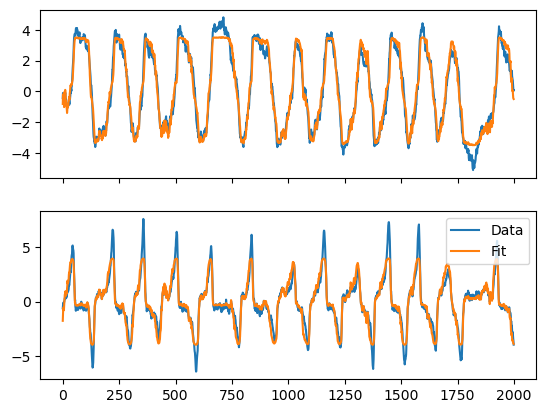

In [56]:
# regress to account for invariance
X_hat = m_gauss #rearrange(m_vdp, 'batch time lat ->  (batch time) lat')
S = np.linalg.pinv(X_hat) @ X.reshape(n_time_bins, n_latents)
X_hat_tilde = X_hat @ S
X_hat_tilde = X_hat_tilde.reshape(n_time_bins, n_latents)

# Plot
fig, axs = plt.subplots(2, 1, sharex='all')
print(f'X_hat shape: {X_hat.shape}')
axs[0].plot(X[:, 0])
axs[0].plot(X_hat_tilde[:, 0])

axs[1].plot(X[:, 1])
axs[1].plot(X_hat_tilde[:, 1])
plt.legend(["Data", "Fit"])
plt.show()

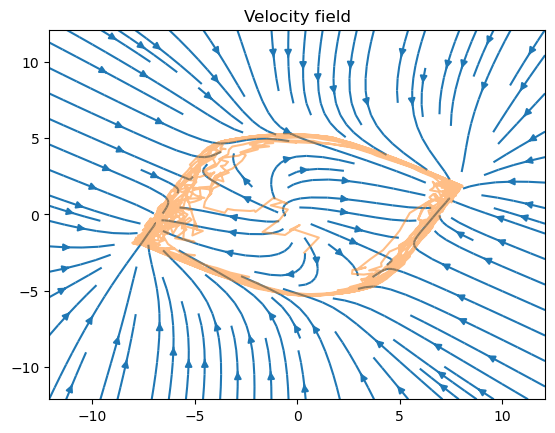

In [57]:
# Draw the inferred velocity field

ax = fig.add_subplot(223)
r = np.mean(np.abs(m_gauss).max())  # determine the limits of plot

Xm, Ym, XYm = grid(51, [-1.5*r, 1.5*r])
Um, Vm = model_gauss.transition.velocity(torch.tensor(XYm)).detach().numpy().T  # get velocity
Um = np.reshape(Um, Xm.shape)
Vm = np.reshape(Vm, Ym.shape)
plt.streamplot(Xm, Ym, Um, Vm)
plt.plot(*m_gauss.T, color='C1', alpha=0.5, zorder=5)
plt.title('Velocity field');